# Import libraries and initialize const

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, losses, optimizers, metrics, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
import re

2025-08-26 05:47:52.043310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
VOCAB_SIZE = 25000
MAXLEN = 256
EMBED_DIM = 64
BATCH_SIZE = 64
EPOCHS = 100
SEED = 42

# Load and split the data

In [3]:
def load_imdb_numpy(num_words=VOCAB_SIZE, split=(0.8, 0.1, 0.1), seed=SEED):
    train_ratio, val_ratio, test_ratio = split

    # 1) Load 50k mẫu (25k train + 25k test) và giới hạn từ vựng cho phù hợp mô hình
    (x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.imdb.load_data(num_words=num_words)

    # 2) Gộp toàn bộ để chủ động chia 8:1:1 (tối đa hóa dữ liệu train)
    x_all = np.array(list(x_tr) + list(x_te), dtype=object)
    y_all = np.array(list(y_tr) + list(y_te), dtype=np.int32)

    # 3) Chia train vs temp (val+test) có stratify để cân bằng nhãn
    X_train, X_temp, y_train, y_temp = train_test_split(
        x_all, y_all,
        test_size=val_ratio + test_ratio,
        random_state=seed,
        shuffle=True,
        stratify=y_all
    )

    # 4) Chia tiếp temp thành val và test theo tỉ lệ yêu cầu (giữ stratify)
    temp_val_fraction = val_ratio / (val_ratio + test_ratio) if (val_ratio + test_ratio) > 0 else 0
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=1 - temp_val_fraction,
        random_state=seed,
        shuffle=True,
        stratify=y_temp
    )

    # 5) Đảm bảo tất cả là NumPy arrays (x là object array, y là int32)
    X_train = np.array(X_train, dtype=object)
    X_val   = np.array(X_val,   dtype=object)
    X_test  = np.array(X_test,  dtype=object)

    y_train = np.array(y_train, dtype=np.int32)
    y_val   = np.array(y_val,   dtype=np.int32)
    y_test  = np.array(y_test,  dtype=np.int32)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = load_imdb_numpy(num_words=VOCAB_SIZE, split=(0.8, 0.1, 0.1), seed=SEED)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Preprocessing data
---



In [5]:
X_train = pad_sequences(X_train, maxlen=MAXLEN, padding="post", truncating="pre", value=0)
X_val = pad_sequences(X_val, maxlen=MAXLEN, padding="post", truncating="pre", value=0)
X_test = pad_sequences(X_test, maxlen=MAXLEN, padding="post", truncating="pre", value=0)

train = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(buffer_size=10000, seed=SEED, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE, drop_remainder = True)
            .prefetch(tf.data.AUTOTUNE))

val  = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
           .batch(BATCH_SIZE, drop_remainder = False)
           .cache()
           .prefetch(tf.data.AUTOTUNE))

test = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
           .batch(BATCH_SIZE, drop_remainder =False)
           .cache()
           .prefetch(tf.data.AUTOTUNE))

I0000 00:00:1756187307.121726    3240 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10274 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:82:00.0, compute capability: 8.6


# Build model

In [6]:
def build_birnn():
    stacked_model = models.Sequential([
      layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN, mask_zero=True),
      layers.SpatialDropout1D(0.2),
      layers.Bidirectional(
            layers.SimpleRNN(64, activation="tanh",
                             dropout=0.2,
                             return_sequences=True),  # phát ra [B, T, 2*64] sau merge
            merge_mode="concat"),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.5),
      layers.Dense(32, activation="relu"),
      layers.Dropout(0.5),
      layers.Dense(1, activation="sigmoid")
     ])
    stacked_model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-3),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )
    return stacked_model

def build_bilstm(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, maxlen=MAXLEN, units=64, merge_mode="concat"):
    inputs = layers.Input(shape=(maxlen,), dtype="int32")

    # Embedding + SpatialDropout
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)

    x = layers.Bidirectional(
            layers.LSTM(units=units, return_sequences=True),
            merge_mode=merge_mode
        )(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(units // 2, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-2),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )
    return model

def build_bigru(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, maxlen=MAXLEN,
                units=64, merge_mode="concat"):
    inputs = layers.Input(shape=(maxlen,), dtype="int32")

    # Embedding + SpatialDropout
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)

    x = layers.Bidirectional(
            layers.GRU(units,
                       return_sequences=True,
                       reset_after=True),
            merge_mode=merge_mode
        )(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(units // 2, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-3),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )
    return model

def build_Conv1D(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, maxlen=MAXLEN):
    inputs = layers.Input(shape=(maxlen,), dtype="int32")
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-3),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )
    return model

# Train model

In [7]:
birnn = build_birnn()
bilstm = build_bilstm()
bigru = build_bigru()
Conv1D = build_Conv1D()

callbacks = [
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5)
]

history_birnn = birnn.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)
history_bilstm = bilstm.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)
history_bigru = bigru.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)
history_Conv1D = Conv1D.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

/venv/main/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask at

Epoch 1/100


2025-08-26 05:49:05.672284: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f1548013990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-26 05:49:05.672323: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-08-26 05:49:05.861445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-26 05:49:06.537587: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-26 05:49:07.226687: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-26 05:49:07.226761: I e

  2/625 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.4336 - loss: 0.6954   

I0000 00:00:1756187355.831637    3550 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7407 - loss: 0.5055

2025-08-26 05:49:54.230940: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-26 05:49:55.678193: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 360 bytes spill stores, 360 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 72ms/step - accuracy: 0.8338 - loss: 0.4141 - val_accuracy: 0.8928 - val_loss: 0.3294 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9221 - loss: 0.2908 - val_accuracy: 0.8880 - val_loss: 0.3284 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9462 - loss: 0.2508 - val_accuracy: 0.8852 - val_loss: 0.3498 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9584 - loss: 0.2292 - val_accuracy: 0.8822 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.9670 - loss: 0.2157 - val_accuracy: 0.8776 - val_loss: 0.3820 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.9808 - loss: 0.1913 - val_accuracy: 0.8746 - val_loss: 0.3997 - learning_rate: 5.0000e-04
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9847 - lo

# Evaluate

In [8]:
import matplotlib.pyplot as plt

def plot_train_val_loss(history, title="Training vs Validation Loss"):
    # history: đối tượng trả về bởi model.fit(...) hoặc dict history.history
    hist = history.history if hasattr(history, "history") else history

    train_loss = hist.get("loss")
    val_loss   = hist.get("val_loss")
    if train_loss is None or val_loss is None:
        raise ValueError('Thiếu "loss" hoặc "val_loss" trong history. Hãy đảm bảo fit có validation_data.')

    epochs = range(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, val_loss,   label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

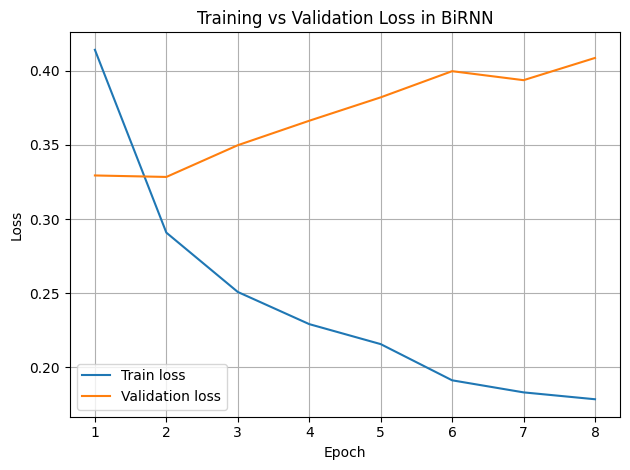

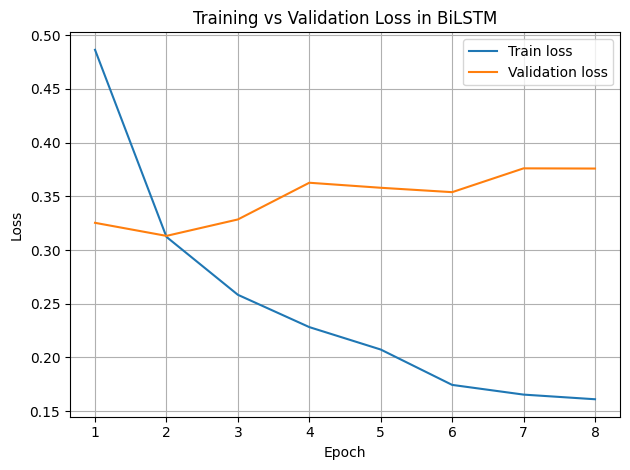

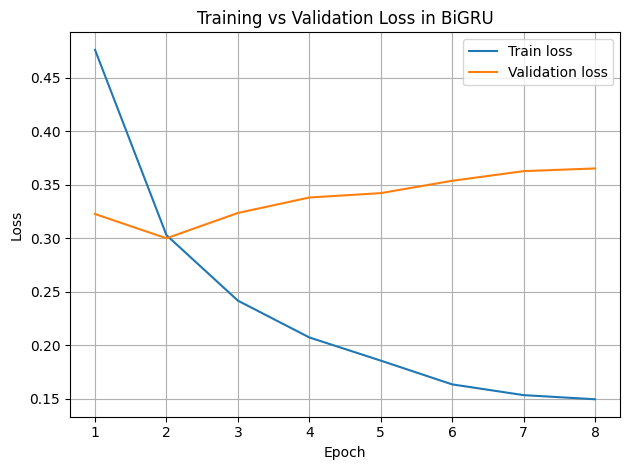

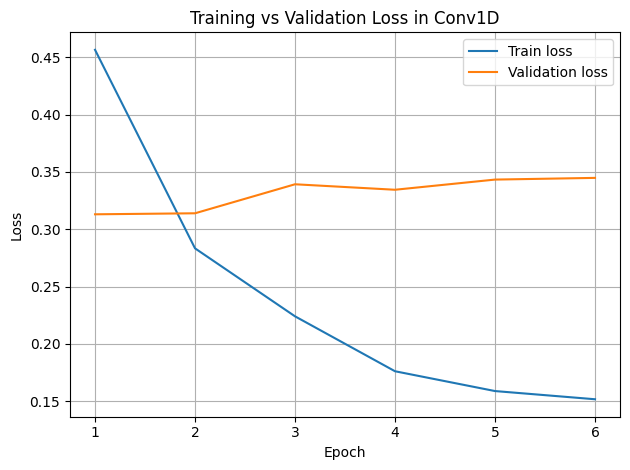

In [9]:
plot_train_val_loss(history_birnn, title = "Training vs Validation Loss in BiRNN")
plot_train_val_loss(history_bilstm, title = "Training vs Validation Loss in BiLSTM")
plot_train_val_loss(history_bigru, title = "Training vs Validation Loss in BiGRU")
plot_train_val_loss(history_Conv1D, title = "Training vs Validation Loss in Conv1D")

In [10]:
test_loss, test_acc = birnn.evaluate(test, verbose=0)
print(f"Test (weighted) loss in BiRNN: {test_loss:.4f} | acc: {test_acc:.4f}")
test_loss, test_acc = bilstm.evaluate(test, verbose=0)
print(f"Test (weighted) loss in BiLSTM: {test_loss:.4f} | acc: {test_acc:.4f}")
test_loss, test_acc = bigru.evaluate(test, verbose=0)
print(f"Test (weighted) loss in BiGRU: {test_loss:.4f} | acc: {test_acc:.4f}")
test_loss, test_acc = Conv1D.evaluate(test, verbose=0)
print(f"Test (weighted) loss in Conv1D: {test_loss:.4f} | acc: {test_acc:.4f}")

Test (weighted) loss in BiRNN: 0.3341 | acc: 0.8870
Test (weighted) loss in BiLSTM: 0.3168 | acc: 0.9004
Test (weighted) loss in BiGRU: 0.3034 | acc: 0.9012
Test (weighted) loss in Conv1D: 0.3229 | acc: 0.8990


# Test with one model

In [11]:
INDEX_FROM = 3     # offset 3: 0=PAD, 1=START, 2=OOV
START = 1
OOV = 2
PAD = 0

VOCAB_SIZE = 25000
MAXLEN = 256

# Tải word_index gốc rồi cộng offset=3 để khớp với dữ liệu train
_raw_wi = imdb.get_word_index()
word_index = {w: (i + INDEX_FROM) for w, i in _raw_wi.items()}

def encode_imdb_text(text, vocab_size=VOCAB_SIZE, maxlen=MAXLEN):
    """
    text -> sequence chỉ số theo quy ước IMDB (START=1, OOV=2, PAD=0)
    - lowercase + tách token đơn giản
    - từ nào không có trong word_index hoặc >= vocab_size -> OOV
    - pad về maxlen với PAD=0, truncating='pre' để khớp pipeline lúc train
    """
    # tách token: chữ, số, apostrophe
    tokens = re.findall(r"[a-z0-9']+", text.lower())

    seq = [START]
    for w in tokens:
        idx = word_index.get(w, OOV)
        if idx >= vocab_size:
            idx = OOV
        seq.append(idx)

    x = pad_sequences([seq], maxlen=maxlen, padding="post", truncating="pre", value=PAD)
    return x  # shape (1, maxlen) int32

def predict_sentence(text, model, threshold=0.5,):
    """
    Trả về (prob_positive, label_str).
    Yêu cầu: biến 'model' đã là model Keras bạn huấn luyện trước đó.
    """
    x = encode_imdb_text(text)
    prob = float(model.predict(x, verbose=0)[0, 0])  # xác suất positive
    label = "positive" if prob >= threshold else "negative"
    return prob, label

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [12]:
sentence = "So fucking bad"
x_demo = encode_imdb_text(sentence)
prob, label = predict_sentence(sentence, bilstm)
print(f"Prob positive: {prob:.3f}  -->  {label}")

Prob positive: 0.231  -->  negative
